<a href="https://colab.research.google.com/github/roulupen-mldl/EVA7/blob/main/Session_2_5_PyTorch_101.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor, Lambda
from torch.utils.data import Dataset
from torchvision.transforms.functional import to_tensor

import matplotlib.pyplot as plt

In [2]:
class CustomMNIST(Dataset):
  def __init__(self, mnist_data):
    self.mnist = mnist_data
    self.mnist.data = self.mnist.data.float()
    random_num = torch.randint(0, 9, (len(mnist_data),) )
    self.random_num_one_hot = F.one_hot(random_num, num_classes=10)

    sum_output = random_num + self.mnist.targets
    self.output_one_hot = torch.cat((torch.reshape(self.mnist.targets, (len(mnist_data), 1)), torch.reshape(sum_output, (len(mnist_data), 1))), 1)
    #self.output_one_hot = torch.cat((F.one_hot(self.mnist.targets, num_classes=10), F.one_hot(random_num + self.mnist.targets, num_classes=19)), dim=1)

  def __getitem__(self, index):
    return (torch.reshape(self.mnist.data[index], (1, 28, 28)), self.random_num_one_hot[index].float(), self.output_one_hot[index])

  def __len__(self):
    return len(self.mnist)


In [3]:
mnist_train_set = datasets.MNIST(
    root='../data',
    train=True,
    download=True,
    transform = transforms.ToTensor()
)

mnist_test_set = datasets.MNIST(
    root='../data',
    train=False,
    download=True,
    transform = transforms.ToTensor()
)

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
custom_mnist_train = CustomMNIST(mnist_train_set)
custom_mnist_test = CustomMNIST(mnist_test_set)

print(len(custom_mnist_train), len(custom_mnist_test))

60000 10000


In [5]:
torch.manual_seed(1)
batch_size = 128
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(custom_mnist_train, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(custom_mnist_test, batch_size=batch_size, shuffle=True, **kwargs)

In [6]:
data=iter(train_loader)
images, random_nums, output = next(data)
print(f"number of samples{images.shape} {images.dtype}")
print(f"number of labels {random_nums.shape} {random_nums.dtype}")
print(f"Outout {output.shape} {output.dtype}")

number of samplestorch.Size([128, 1, 28, 28]) torch.float32
number of labels torch.Size([128, 10]) torch.float32
Outout torch.Size([128, 2]) torch.int64


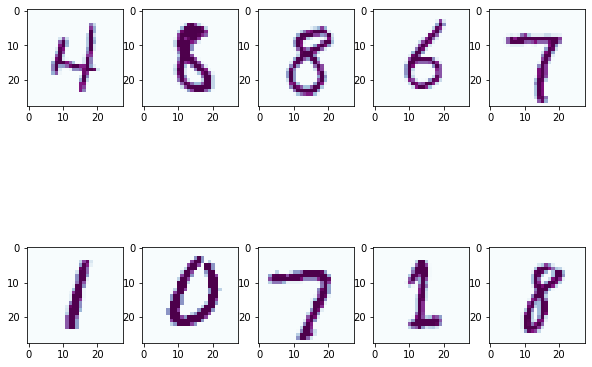

In [7]:
plt.figure(figsize=(10,8))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(images[i][0], cmap='BuPu')
plt.show()

## Model

In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1) 
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1) 
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv5 = nn.Conv2d(256, 512, 3)
        self.conv6 = nn.Conv2d(512, 1024, 3)
        self.conv7 = nn.Conv2d(1024, 10, 3)
        
        # First fully connected layer
        self.fc1 = nn.Linear(9216, 128)

        # Fully connected layer for sum number
        self.fcsum = nn.Linear(10, 20)
        
        # Second fully connected layer that outputs our 10 labels
        self.fc2 = nn.Linear(148, 29) # First 1 for predicting image and next 19 for sum calculation

    def forward(self, x, num):
        x = self.pool1(F.relu(self.conv2(F.relu(self.conv1(x))))) # 28 x 28 x 1 | 14 x 14 x 64, RF = 8 x 8
        x = self.pool2(F.relu(self.conv4(F.relu(self.conv3(x))))) # 14 x 14 x 64 | 7 x 7 x 256, RF = 24 x 14
        x = F.relu(self.conv6(F.relu(self.conv5(x)))) # 7 x 7 x 256 | 3 x 3 x 1024, 28 x 28

        x = torch.flatten(x, 1)
        num = torch.flatten(num, 1)

        # Pass data through fc1
        x = F.relu(self.fc1(x))

        # First FC layer for random number
        num = F.relu(self.fcsum(num))

        # Concatenating X FC to num FC
        x = torch.cat((x, num), 1)

        # Pass data through fc2
        x = F.relu(self.fc2(x))

        #x = F.relu(self.conv7(x)) # 3 x 3 x 1024 | 1 x 1 x 10
        x = x.view(-1, 29)
        x = F.log_softmax(x, dim=1)
        return x # applying softmax activation for final classification

In [9]:
from tqdm import tqdm

def get_num_correct(preds, labels):
   return preds.argmax(dim=1).eq(labels).sum().item()

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)

    total_correct_img = 0
    total_correct_sum = 0
    for batch_idx, (data, input_num, target) in enumerate(pbar):      
      data, input_num, target = data.to(device), input_num.to(device), target.to(target)
      optimizer.zero_grad()
      output = model(data, input_num)

      output1, output2 = torch.tensor_split(output, (10,), dim=1)
      target1, target2 = torch.tensor_split(target, (1,), dim=1)

      target1 = torch.squeeze(target1).to(device)
      target2 = torch.squeeze(target2).to(device)

      loss1 = F.cross_entropy(output1, target1)
      loss2 = F.cross_entropy(output2, target2)

      loss = loss1 + loss2
      loss.cuda()
      loss.backward()
      optimizer.step()

      total_correct_img += get_num_correct(output1, target1)
      total_correct_sum += get_num_correct(output2, target2)
      
      pbar.set_description(desc= f'loss={loss.item()} total_correct_img={total_correct_img} total_correct_sum={total_correct_sum}  batch_id={batch_idx}')


In [10]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

for epoch in range(1, 11):
    train(model, device, train_loader, optimizer, epoch)

  0%|          | 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
loss=3.1988210678100586 total_correct_img=51794 total_correct_sum=1128  batch_id=468: 100%|██████████| 469/469 [00:35<00:00, 13.29it/s]
loss=3.1424832344055176 total_correct_img=53603 total_correct_sum=682  batch_id=468: 100%|██████████| 469/469 [00:35<00:00, 13.28it/s]
loss=3.2306032180786133 total_correct_img=53774 total_correct_sum=683  batch_id=468: 100%|██████████| 469/469 [00:35<00:00, 13.33it/s]
loss=3.305115222930908 total_correct_img=53880 total_correct_sum=745  batch_id=468: 100%|██████████| 469/469 [00:35<00:00, 13.27it/s]
loss=3.0899140834